In [1]:
%load_ext autoreload
%autoreload 2

import numpy
import matplotlib as mpl
import matplotlib.pyplot as plt

from utils import *

mpl.rcParams['mathtext.default'] = 'regular'
cmap = mpl.colormaps['plasma']

In [2]:
sheet_names = ['V1_Exc_L4', 'V1_Inh_L4', 'V1_Exc_L2/3', 'V1_Inh_L2/3']
sheet_names_formatted = {
    'V1_Exc_L4': "Layer 4 Exc.",
    'V1_Inh_L4': "Layer 4 Inh.",
    'V1_Exc_L2/3': "Layer 2/3 Exc.",
    'V1_Inh_L2/3': "Layer 2/3 Inh.",
}

In [3]:
class CellRate():

    def __init__(self, prefered_orientation=None):
        self.prefered_orientation = prefered_orientation
        self.gratings_rates = []
        self.gratings_orientations = []
        self.gratings_radius = []
        self.spont_rate = []

    @property
    def grating_orientation_relative(self):
        _rel_orient = []
        for go in self.gratings_orientations:
            _diff = go - self.prefered_orientation
            if _diff < - (numpy.pi / 2):
                _diff += numpy.pi
            if _diff > numpy.pi / 2:
                _diff -= numpy.pi
            _rel_orient.append(_diff)
        return _rel_orient

    def get_mean_rate_for_radius(self, target_radius):
        if not cell.spont_rate:
            return numpy.nan

        _rates = []
        for radius, rate in zip(self.gratings_radius, self.gratings_rates):
            if numpy.isclose(radius, target_radius, atol=0.05):
                _rates.append(rate)# / self.spont_rate)

        return numpy.nanmean(_rates)

# Spontaneous

In [4]:
run_id = "20250123-202636"
for sheet_name in sheet_names:
    datastore_to_pickle(run_id, sheet_name)
data_store = get_data_stores(run_id)[0]

Did not pickle 20250121-132347 because it has already been pickled
Did not pickle 20250121-132347 because it has already been pickled
Did not pickle 20250121-132347 because it has already been pickled
Did not pickle 20250121-132347 because it has already been pickled
Reading folder ./20250121-132347[param.defaults]CombinationParamSearch{25}/SelfSustainedPushPull_ParameterSearch_____pynn_seed:1_base_weight:2.543e-05_base_weight:0.00014197_b


In [5]:
# Get the spont activity
data_per_sheet = {}
for sheet_name in sheet_names:
    data = read_pickled_datastore(run_id, sheet_name)
    data_per_sheet[sheet_name] = next(seg for seg in data if 'orientation' not in seg.annotation)

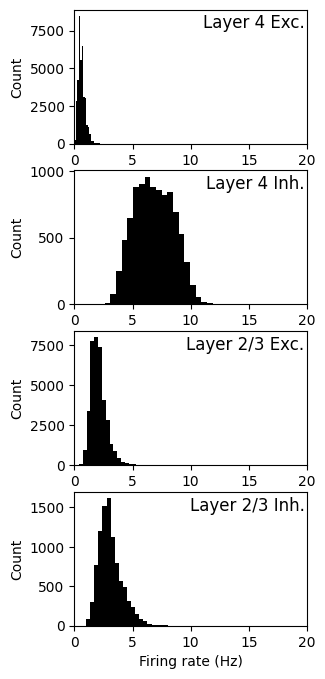

In [6]:
# SANITY TEST:
tolerance = 0.1 # rad
fig, axs = plt.subplots(4, figsize=(3, 8))
for idx_ax, sheet_name in enumerate(sheet_names):
    spont_seg = data_per_sheet[sheet_name]
    axs[idx_ax].hist([1000. * len(st) / spont_seg.duration for st in spont_seg.spiketrains], color="black", bins=20)
    axs[idx_ax].set_ylabel("Count")
    axs[idx_ax].set_xlim(0, 20)
    axs[idx_ax].set_title(sheet_names_formatted[sheet_name], x=0.99, y=0.80, ha='right') 
axs[-1].set_xlabel("Firing rate (Hz)")

plt.savefig(f"./figures/hist_firing_rate_{run_id}.png", dpi=100, bbox_inches="tight", transparent=True)
plt.show()

/home/tanguy.damart/virt_env/mozaik/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/tanguy.damart/virt_env/mozaik/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/tanguy.damart/virt_env/mozaik/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/tanguy.damart/virt_env/mozaik/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tanguy.damart/virt_env/mozaik/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


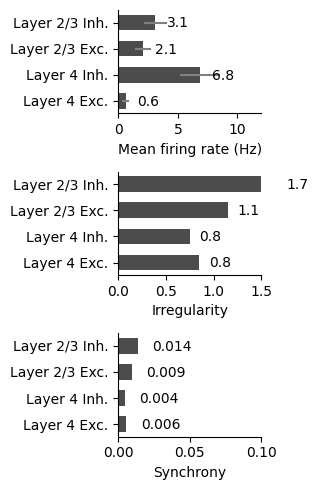

In [7]:
fig, axs = plt.subplots(3, figsize=(3.5, 5))

# Plot the spont activity rate/CC/CV with error bar
for ypos, (sheet_name, seg) in enumerate(data_per_sheet.items()):
    mean_rate = float(seg.mean_rate)
    std_rate = float(numpy.std([1000. * len(s) / seg.duration for s in seg.spiketrains]))
    axs[0].barh(ypos, mean_rate, height=0.6, color="black", alpha=0.7)
    axs[0].errorbar(mean_rate, ypos, xerr=float(std_rate), color="gray")
    axs[0].text(mean_rate + 1, ypos - 0.19, f"{mean_rate:.1f}")

axs[0].set_xlim(0, 12)
axs[0].set_xlabel("Mean firing rate (Hz)")

# Plot the Irregularity (CV)
for ypos, (sheet_name, seg) in enumerate(data_per_sheet.items()):
    isis = [numpy.diff(st) for st in seg.spiketrains]
    idxs = numpy.array([len(isi) for isi in isis]) > 5
    cvs = numpy.array([numpy.std(isi) / numpy.mean(isi) for isi in isis])[idxs]
    cv_mean = float(numpy.mean(cvs))
    cv_std = float(numpy.std(cvs))
    axs[1].barh(ypos, cv_mean, height=0.6, color="black", alpha=0.7)
    axs[1].errorbar(mean_rate, ypos, xerr=cv_std, color="gray")
    axs[1].text(cv_mean + 0.1, ypos - 0.19, f"{cv_mean:.1f}")

axs[1].set_xlim(0, 1.5)
axs[1].set_xlabel("Irregularity")

# Plot the Synchrony (CV)
for ypos, (sheet_name, seg) in enumerate(data_per_sheet.items()):
    spiketrains = seg.spiketrains[:2000]
    isis = [numpy.diff(st) for st in spiketrains]
    idxs = numpy.array([len(isi) for isi in isis]) > 5
    num_bins = int(seg.duration / 10.)
    r = (float(round(seg.t_start, 5)), float(round(seg.t_stop, 5)))
    psths = [numpy.histogram(x, bins=num_bins, range=r)[0] for x in spiketrains]
    corrs = numpy.nan_to_num(numpy.corrcoef(numpy.squeeze(psths)))
    ccs = corrs[idxs, :][:, idxs][numpy.triu_indices(sum(idxs == True), 1)]
    cc_mean = float(numpy.mean(ccs))
    cc_std = float(numpy.std(ccs))
    axs[2].barh(ypos, cc_mean, height=0.6, color="black", alpha=0.7)
    axs[2].errorbar(mean_rate, ypos, xerr=cc_std, color="gray")
    axs[2].text(cc_mean + 0.01, ypos - 0.19, f"{cc_mean:.3f}")

axs[2].set_xlim(0, 0.1)
axs[2].set_xlabel("Synchrony")

for ax in axs:
    ax.set_yticks(list(range(len(data_per_sheet))))
    ax.set_yticklabels([sheet_names_formatted[n] for n in data_per_sheet.keys()])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()

plt.savefig(f"./figures/spontaneous_activity_{run_id}.png", dpi=100, bbox_inches="tight", transparent=True)
plt.show()

# Orientation tuning

In [8]:
run_id = "20250123-202636"
for sheet_name in sheet_names:
    datastore_to_pickle(run_id, sheet_name)

Did not pickle 20250121-132347 because it has already been pickled
Did not pickle 20250121-132347 because it has already been pickled
Did not pickle 20250121-132347 because it has already been pickled
Did not pickle 20250121-132347 because it has already been pickled


In [9]:
# Get the OT activity
data_per_sheet = {}
data_spont_per_sheet = {}
data_store = get_data_stores(run_id)[0]
for sheet_name in sheet_names:
    data = read_pickled_datastore(run_id, sheet_name)
    data_per_sheet[sheet_name] = [seg for seg in data if 'orientation' in seg.annotation]
    data_spont_per_sheet[sheet_name] = next(seg for seg in data if 'orientation' not in seg.annotation)

Reading folder ./20250121-132347[param.defaults]CombinationParamSearch{25}/SelfSustainedPushPull_ParameterSearch_____pynn_seed:1_base_weight:2.543e-05_base_weight:0.00014197_b


NeuronAnnotationsToPerNeuronValues analysis took: 0.6458637714385986 seconds


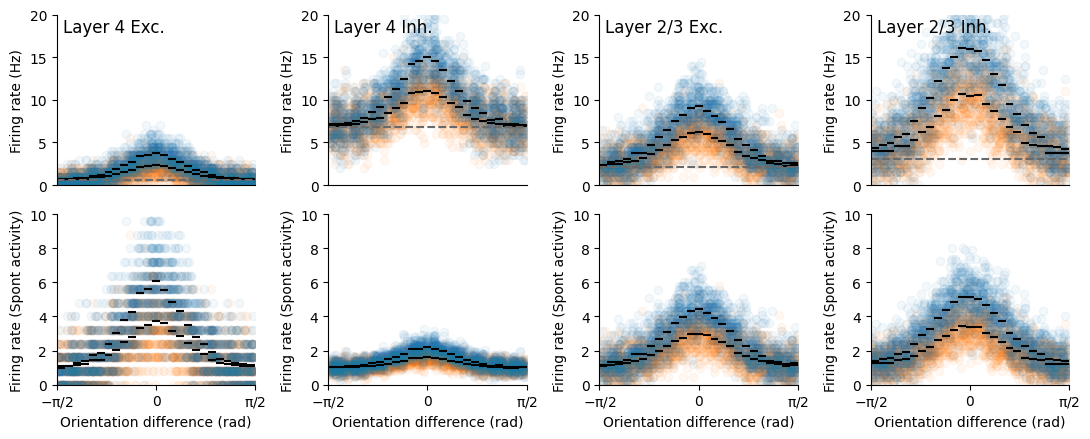

In [10]:
from scipy import stats

fig, axs = plt.subplots(2, 4, figsize=(11, 4.5))

for idx_plot, sheet_name in enumerate(sheet_names):

    orientations_cells = get_orientation_preference(data_store, sheet_name).values

    for contrast in [10, 100]:

        cells = [CellRate(oc) for oc in orientations_cells]

        # Get the gratings fire rate
        for seg in data_per_sheet[sheet_name]:
            if seg.annotation["contrast"] == contrast:
                for idx, st in enumerate(seg.spiketrains):
                    cells[idx].gratings_rates.append(1000. * len(st) / seg.duration)
                    cells[idx].gratings_orientations.append(seg.annotation["orientation"])

        # Binning
        x = []
        y = []
        for cell in cells[:400]:
            x += cell.grating_orientation_relative
            y += cell.gratings_rates
        bin_means, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='mean', bins=25, range=(-numpy.pi / 2, numpy.pi / 2))
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2

        color = "C0" if contrast == 100 else "C1"
        for cell in cells[:100]:
            axs[0][idx_plot].scatter(cell.grating_orientation_relative, cell.gratings_rates, color=color, alpha=0.05)
            axs[1][idx_plot].scatter(cell.grating_orientation_relative, cell.gratings_rates / data_spont_per_sheet[sheet_name].mean_rate, color=color, alpha=0.05)

        axs[0][idx_plot].hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='black', lw=1.5)
        axs[1][idx_plot].hlines(bin_means / data_spont_per_sheet[sheet_name].mean_rate, bin_edges[:-1], bin_edges[1:], colors='black', lw=1.5)
        axs[0][idx_plot].set_title(sheet_names_formatted[sheet_name], x=0.03, y=0.85, ha='left') 

    # Spontaneous rate
    axs[0][idx_plot].axhline(data_spont_per_sheet[sheet_name].mean_rate, color='dimgray', lw=1.5, ls='--')

for ax in axs[0]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(-numpy.pi / 2, numpy.pi / 2)
    ax.set_ylim(0, 20)
    ax.set_ylabel("Firing rate (Hz)")
    ax.set_xticks([])
    ax.set_xticklabels([])

for ax in axs[1]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(-numpy.pi / 2, numpy.pi / 2)
    ax.set_ylim(0, 10)
    ax.set_ylabel("Firing rate (Spont activity)")
    ax.set_xlabel("Orientation difference (rad)")
    ax.set_xticks([-numpy.pi / 2, 0, numpy.pi / 2])
    ax.set_xticklabels([r'$-\pi /2$', '0', r'$\pi /2$'])

plt.tight_layout()

plt.savefig(f"./figures/orientation_tuning_{run_id}.png", dpi=100, bbox_inches="tight", transparent=True)
plt.show()

# Size tuning

In [11]:
run_id = "20250124-090804"
tolerance = 0.1  # rad
contrast = 100

for sheet_name in ['V1_Exc_L4', 'V1_Inh_L4', 'V1_Exc_L2/3', 'V1_Inh_L2/3']:
    datastore_to_pickle(run_id, sheet_name)

Did not pickle 20250121-132417 because it has already been pickled
Did not pickle 20250121-132417 because it has already been pickled
Did not pickle 20250121-132417 because it has already been pickled
Did not pickle 20250121-132417 because it has already been pickled


In [12]:
# Get the ST activity
data_per_sheet = {}
data_spont_per_sheet = {}
data_store = get_data_stores(run_id)[0]
for sheet_name in sheet_names:
    data = read_pickled_datastore(run_id, sheet_name)
    data_per_sheet[sheet_name] = [seg for seg in data if 'orientation' in seg.annotation]
    data_spont_per_sheet[sheet_name] = next(seg for seg in data if 'orientation' not in seg.annotation)

Reading folder ./20250121-132417[param.defaults]CombinationParamSearch{25}/SelfSustainedPushPull_ParameterSearch_____pynn_seed:1_base_weight:2.543e-05_base_weight:0.00014197_b


In [13]:
# Size tuning based on fitting with sum of gaussians
from scipy.optimize import differential_evolution
from scipy.special import erf


def sum_of_gaussian(p, x):
        return (p[0] * erf(x / p[1])**2
                - p[2] * erf(x / (p[1] + p[3]))**2
                + p[4] * erf(x / (p[1] + p[3] + p[5]))**2
                + p[6])


def error_function_evo(p, *args):
    x, y = args
    return numpy.linalg.norm(sum_of_gaussian(p, x) - y)


sheet_name = sheet_names[2]

spont_segment = data_spont_per_sheet[sheet_name]
grating_segments = data_per_sheet[sheet_name]

gratings_orientations = set([seg.annotation['orientation'] for seg in grating_segments if 'orientation' in seg.annotation])
orientations_cells = get_orientation_preference(data_store, sheet_name).values

cells = [CellRate(oc) for oc in orientations_cells]
for idx, st in enumerate(spont_segment.spiketrains):
    cells[idx].spont_rate = 1000. * len(st) / spont_segment.duration

# Get the gratings fire rate
for orientation in gratings_orientations:
    for seg in grating_segments:
        if 'contrast' in seg.annotation and seg.annotation["contrast"] == contrast:
            for idx, st in enumerate(seg.spiketrains):
                if numpy.isclose(cells[idx].prefered_orientation, seg.annotation["orientation"], atol=tolerance):
                    cells[idx].gratings_rates.append(1000. * len(st) / seg.duration)
                    cells[idx].gratings_orientations.append(seg.annotation["orientation"])
                    cells[idx].gratings_radius.append(seg.annotation["radius"])

cells = [c for c in cells if len(c.gratings_rates)]
radiuses = sorted(list(set([seg.annotation["radius"] for seg in grating_segments if 'radius' in seg.annotation])))

crf_sizes = []
supp_sizes = []
sis = []
max_responses = []
csis = []
errs = []

for idx_cell, cell in enumerate(cells):

    print(idx_cell, len(cells))

    values = [cell.get_mean_rate_for_radius(radius) for radius in radiuses]
    rads = list(radiuses)

    rads, values = zip(*sorted(zip(rads,values)))
    rads = numpy.array(rads)
    values = numpy.array(values)

    res = differential_evolution(
        error_function_evo,
        bounds=[(0, 60), (0, 20), (0, 60), (0, 15), (0, 15), (0, 25), (0, 5)],
        args=(rads, values),
        strategy='rand2bin',
        maxiter=10000,
        popsize=30,
        tol=0.1,
        mutation=(0.5, 1.5),
        recombination=0.95,
        workers=1,
    )
    #print(f"Residual loss evo: {error_function_evo(res.x, *(rads, values))}")
    errs.append(error_function_evo(res.x, *(rads, values)))

    X_fit = numpy.linspace(0, 5, 100)
    values_fit = sum_of_gaussian(res.x, X_fit)

    if False:
        fig, ax = plt.subplots(1, figsize=(3, 2))
        ax.scatter(rads, values, color="black")
        ax.plot(X_fit, values_fit)
        plt.show()

    max_response = numpy.max(values_fit)
    crf_index  = numpy.argmax(values_fit)
    crf_size = X_fit[crf_index]

    if crf_index < len(values_fit)-1:
        supp_index = crf_index+numpy.argmin(values_fit[crf_index+1:])+1
    else:
        supp_index = len(values_fit)-1
    supp_size = X_fit[supp_index]

    if supp_index < len(values_fit)-1:
        cs_index = supp_index+numpy.argmax(values_fit[supp_index+1:])+1
    else:
        cs_index = len(values_fit)-1

    if values_fit[crf_index] != 0:
        si = (values_fit[crf_index]-values_fit[supp_index])/values_fit[crf_index]
    else:
        si = 0

    if values_fit[cs_index] != 0:
        csi = (values_fit[cs_index]-values_fit[supp_index])/values_fit[crf_index]
    else:
        csi = 0

    crf_sizes.append(crf_size)
    supp_sizes.append(supp_size)
    sis.append(si)
    max_responses.append(max_response)
    csis.append(csi)

NeuronAnnotationsToPerNeuronValues analysis took: 0.7325141429901123 seconds


0 1325
1 1325
2 1325
3 1325
4 1325
5 1325
6 1325
7 1325
8 1325
9 1325
10 1325
11 1325
12 1325
13 1325
14 1325
15 1325
16 1325
17 1325
18 1325
19 1325
20 1325
21 1325
22 1325
23 1325
24 1325
25 1325
26 1325
27 1325
28 1325
29 1325
30 1325
31 1325
32 1325
33 1325
34 1325
35 1325
36 1325
37 1325
38 1325
39 1325
40 1325
41 1325
42 1325
43 1325
44 1325
45 1325
46 1325
47 1325
48 1325
49 1325
50 1325
51 1325
52 1325


/tmp/ipykernel_677804/2660420579.py:7: RuntimeWarning: divide by zero encountered in divide
  return (p[0] * erf(x / p[1])**2
/tmp/ipykernel_677804/2660420579.py:8: RuntimeWarning: divide by zero encountered in divide
  - p[2] * erf(x / (p[1] + p[3]))**2


53 1325
54 1325
55 1325
56 1325
57 1325
58 1325
59 1325
60 1325
61 1325
62 1325
63 1325
64 1325
65 1325
66 1325
67 1325
68 1325
69 1325
70 1325
71 1325
72 1325
73 1325
74 1325
75 1325
76 1325
77 1325
78 1325
79 1325
80 1325
81 1325
82 1325
83 1325
84 1325
85 1325
86 1325
87 1325
88 1325
89 1325
90 1325
91 1325
92 1325
93 1325
94 1325
95 1325
96 1325
97 1325
98 1325
99 1325
100 1325
101 1325
102 1325
103 1325
104 1325
105 1325
106 1325
107 1325
108 1325
109 1325
110 1325
111 1325
112 1325
113 1325
114 1325
115 1325
116 1325
117 1325
118 1325
119 1325
120 1325
121 1325
122 1325
123 1325
124 1325
125 1325
126 1325
127 1325
128 1325
129 1325
130 1325
131 1325
132 1325
133 1325
134 1325
135 1325
136 1325
137 1325
138 1325
139 1325
140 1325
141 1325
142 1325
143 1325
144 1325
145 1325
146 1325
147 1325
148 1325
149 1325
150 1325
151 1325
152 1325
153 1325
154 1325
155 1325
156 1325
157 1325
158 1325
159 1325
160 1325
161 1325
162 1325
163 1325
164 1325
165 1325
166 1325
167 1325
168 1325
169

/tmp/ipykernel_677804/2660420579.py:9: RuntimeWarning: divide by zero encountered in divide
  + p[4] * erf(x / (p[1] + p[3] + p[5]))**2


297 1325
298 1325
299 1325
300 1325
301 1325
302 1325
303 1325
304 1325
305 1325
306 1325
307 1325
308 1325
309 1325
310 1325
311 1325
312 1325
313 1325
314 1325
315 1325
316 1325
317 1325
318 1325
319 1325
320 1325
321 1325
322 1325
323 1325
324 1325
325 1325
326 1325
327 1325
328 1325
329 1325
330 1325
331 1325
332 1325
333 1325
334 1325
335 1325
336 1325
337 1325
338 1325
339 1325
340 1325
341 1325
342 1325
343 1325
344 1325
345 1325
346 1325
347 1325
348 1325
349 1325
350 1325
351 1325
352 1325
353 1325
354 1325
355 1325
356 1325
357 1325
358 1325
359 1325
360 1325
361 1325
362 1325
363 1325
364 1325
365 1325
366 1325
367 1325
368 1325
369 1325
370 1325
371 1325
372 1325
373 1325
374 1325
375 1325
376 1325
377 1325
378 1325
379 1325
380 1325
381 1325
382 1325
383 1325
384 1325
385 1325
386 1325
387 1325
388 1325
389 1325
390 1325
391 1325
392 1325
393 1325
394 1325
395 1325
396 1325
397 1325
398 1325
399 1325
400 1325
401 1325
402 1325
403 1325
404 1325
405 1325
406 1325
407 1325
4

In [14]:
# Filter the cell:
sis_filtered = [si for si, er in zip(sis, errs) if er < 3.5]
csis_filtered = [csi for csi, er in zip(csis, errs) if er < 3.5]

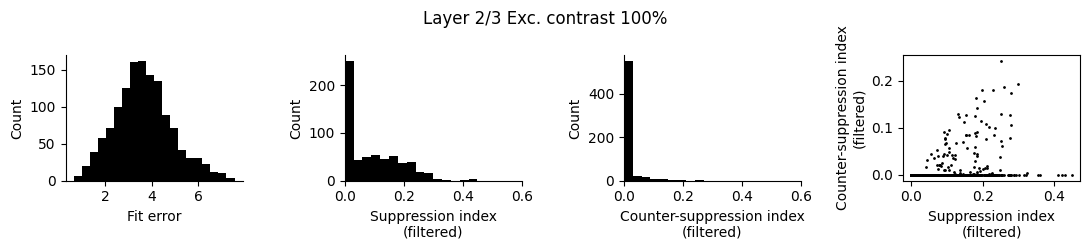

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(11, 2.5))

axs[0].hist(errs, color="black", bins=20)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].set_xlabel("Fit error")
axs[0].set_ylabel("Count")

axs[1].hist(sis_filtered, color="black", range=(0., 0.6), bins=20)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_xlabel("Suppression index\n(filtered)")
axs[1].set_ylabel("Count")
axs[1].set_xlim(0, 0.6)

axs[2].hist(csis_filtered, color="black", range=(0., 0.6), bins=20)
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].set_xlabel("Counter-suppression index\n(filtered)")
axs[2].set_ylabel("Count")
axs[2].set_xlim(0, 0.6)

axs[3].scatter(sis_filtered, csis_filtered, color="black", s=1)
axs[3].set_xlabel("Suppression index\n(filtered)")
axs[3].set_ylabel("Counter-suppression index\n(filtered)")

fig.suptitle(f"{sheet_names_formatted[sheet_name]} contrast 100%")

plt.tight_layout()

plt.savefig(f"./figures/size_tuning_{run_id}.png", dpi=100, bbox_inches="tight", transparent=True)
plt.show()

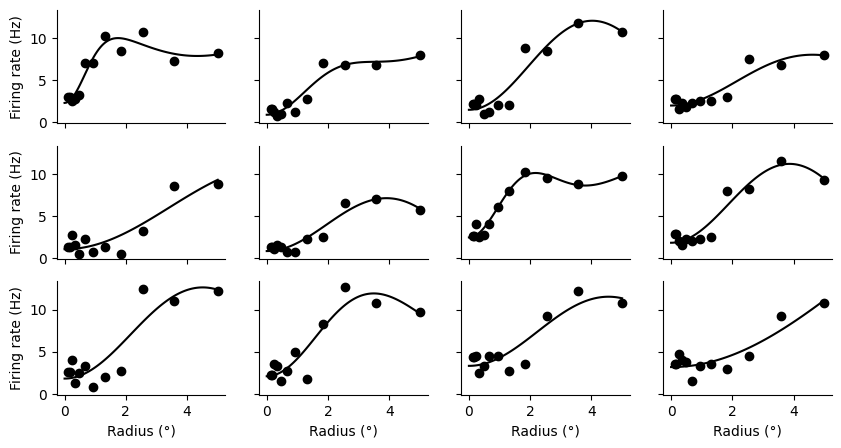

In [16]:
fig, axs = plt.subplots(3, 4, figsize=(10, 5), sharex=True, sharey=True)

for idx_cell, cell in enumerate(cells):

    if idx_cell > 11:
        break

    values = [cell.get_mean_rate_for_radius(radius) for radius in radiuses]
    rads = list(radiuses)

    rads, values = zip(*sorted(zip(rads,values)))
    rads = numpy.array(rads)
    values = numpy.array(values)

    res = differential_evolution(
        error_function_evo,
        bounds=[(0, 60), (0, 20), (0, 60), (0, 15), (0, 15), (0, 25), (0, 5)],
        args=(rads, values),
        strategy='rand2bin',
        maxiter=10000,
        popsize=30,
        tol=0.1,
        mutation=(0.5, 1.5),
        recombination=0.95,
        workers=1,
    )

    X_fit = numpy.linspace(0, 5, 100)
    Y_fit = sum_of_gaussian(res.x, X_fit)

    ax = axs[idx_cell % 3, idx_cell // 3]
    ax.scatter(rads, values, color="black")
    ax.plot(X_fit, Y_fit, color="black")

for ax in axs.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
for col in range(3):
    axs[col, 0].set_ylabel("Firing rate (Hz)")
for row in range(4):
    axs[-1, row].set_xlabel("Radius (°)")

plt.savefig(f"./figures/fit_size_tuning_{run_id}.png", dpi=100, bbox_inches="tight", transparent=True)
plt.show()